In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the dataset
file_path = '/content/metadata.csv'  # Path to the uploaded dataset
dataset = pd.read_csv(file_path)

# Display the first few rows to inspect the dataset
print(dataset.head())


    Sample_ID    Year Country Continent Beta.lactamase Azithromycin  \
0  ERR1549286  2015.0      UK    Europe            NaN         >256   
1  ERR1549290  2015.0      UK    Europe            NaN         >256   
2  ERR1549291  2015.0      UK    Europe            NaN         >256   
3  ERR1549287  2015.0      UK    Europe            NaN         >256   
4  ERR1549288  2015.0      UK    Europe            NaN         >256   

  Ciprofloxacin Ceftriaxone Cefixime Tetracycline  ... log2_cro_mic  \
0           NaN       0.016      NaN          NaN  ...    -5.965784   
1           NaN       0.004      NaN          NaN  ...    -7.965784   
2           NaN       0.006      NaN          NaN  ...    -7.380822   
3           NaN       0.006      NaN          NaN  ...    -7.380822   
4           NaN       0.008      NaN          NaN  ...    -6.965784   

  log2_cfx_mic  log2_tet_mic  log2_pen_mic  azm_sr  cip_sr  cro_sr  cfx_sr  \
0          NaN           NaN           NaN     1.0     NaN     0.0  

In [ ]:
# Check for missing values in each column
missing_values = dataset.isnull().sum()
print("Missing Values:")
print(missing_values)


Missing Values:
Sample_ID            0
Year               250
Country              1
Continent            1
Beta.lactamase    1859
Azithromycin       306
Ciprofloxacin      657
Ceftriaxone        350
Cefixime           381
Tetracycline      2314
Penicillin        2321
NG_MAST              7
Group                0
azm_mic            308
cip_mic            698
cro_mic            352
cfx_mic            385
tet_mic           2314
pen_mic           2321
log2_azm_mic       308
log2_cip_mic       698
log2_cro_mic       352
log2_cfx_mic       385
log2_tet_mic      2314
log2_pen_mic      2321
azm_sr             308
cip_sr             698
cro_sr             352
cfx_sr             385
tet_sr            2314
pen_sr            2321
dtype: int64


In [ ]:
# Fill missing numerical values with the column mean
numeric_columns = dataset.select_dtypes(include=[np.number]).columns
dataset[numeric_columns] = dataset[numeric_columns].fillna(dataset[numeric_columns].mean())

# Fill missing categorical values with the mode
categorical_columns = dataset.select_dtypes(include=[object]).columns
dataset[categorical_columns] = dataset[categorical_columns].fillna(dataset[categorical_columns].mode().iloc[0])

# Verify that there are no more missing values
print("\nMissing Values After Imputation:")
print(dataset.isnull().sum())



Missing Values After Imputation:
Sample_ID         0
Year              0
Country           0
Continent         0
Beta.lactamase    0
Azithromycin      0
Ciprofloxacin     0
Ceftriaxone       0
Cefixime          0
Tetracycline      0
Penicillin        0
NG_MAST           0
Group             0
azm_mic           0
cip_mic           0
cro_mic           0
cfx_mic           0
tet_mic           0
pen_mic           0
log2_azm_mic      0
log2_cip_mic      0
log2_cro_mic      0
log2_cfx_mic      0
log2_tet_mic      0
log2_pen_mic      0
azm_sr            0
cip_sr            0
cro_sr            0
cfx_sr            0
tet_sr            0
pen_sr            0
dtype: int64


In [ ]:
def convert_to_numeric(value):
    # First check if the value is a string
    if isinstance(value, str):
        # Handle cases like '>256', '=512', etc.
        if '>' in value or '=' in value:
            # Remove '>' or '=' and return the numeric value
            try:
                return float(value.replace('>', '').replace('=', ''))
            except ValueError:
                return np.nan  # If conversion fails, return NaN

        # Handle cases like '<0.008' by replacing '<' with an empty string
        elif '<' in value:
            try:
                return float(value.replace('<', ''))  # Remove '<' and convert to float
            except ValueError:
                return np.nan  # If conversion fails, return NaN

        # If it's a valid numeric string, convert it directly
        try:
            return float(value)
        except ValueError:
            return np.nan  # For invalid numeric strings, return NaN

    # If it's already a numeric value (int or float), return it as is
    return value

# Step 1: Identify object columns that might contain numeric-like values
# These columns are object columns, but some of them might contain numeric values in string format
potential_numeric_columns = dataset.select_dtypes(include=[object]).columns

# Step 2: Loop through each potential numeric column and convert
for col in potential_numeric_columns:
    dataset[col] = dataset[col].apply(convert_to_numeric)

# Step 3: Handle missing values for numeric columns (after conversion)
# Loop through numeric columns and fill NaN values with the mean of each column
numeric_columns = dataset.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    dataset[col] = dataset[col].fillna(dataset[col].mean())

# Step 4: Handle missing values for categorical columns
# Loop through categorical columns and fill NaN values with the mode (most frequent value)
categorical_columns = dataset.select_dtypes(include=[object]).columns
for col in categorical_columns:
    dataset[col] = dataset[col].fillna(dataset[col].mode().iloc[0])

# Step 5: Verify if there are still any missing values after imputation
print("\nMissing Values After Imputation:")
print(dataset.isnull().sum())
# Check how many unique values exist in these columns
print(dataset['Country'].value_counts(dropna=False))
print(dataset['Continent'].value_counts(dropna=False))

# Check if there are rows where 'Country' and 'Continent' are still NaN
missing_countries = dataset[dataset['Country'].isnull()]
missing_continents = dataset[dataset['Continent'].isnull()]

# Print out the rows with missing country and continent values
print(missing_countries)
print(missing_continents)



Missing Values After Imputation:
Sample_ID            0
Year                 0
Country           3786
Continent         3786
Beta.lactamase       0
Azithromycin         0
Ciprofloxacin        0
Ceftriaxone          0
Cefixime             0
Tetracycline         0
Penicillin           0
NG_MAST              0
Group                0
azm_mic              0
cip_mic              0
cro_mic              0
cfx_mic              0
tet_mic              0
pen_mic              0
log2_azm_mic         0
log2_cip_mic         0
log2_cro_mic         0
log2_cfx_mic         0
log2_tet_mic         0
log2_pen_mic         0
azm_sr               0
cip_sr               0
cro_sr               0
cfx_sr               0
tet_sr               0
pen_sr               0
dtype: int64
Country
NaN    3786
Name: count, dtype: int64
Continent
NaN    3786
Name: count, dtype: int64
         Sample_ID    Year  Country  Continent  Beta.lactamase  Azithromycin  \
0     14138.043478  2015.0      NaN        NaN        0.102439    

In [ ]:
from sklearn.model_selection import train_test_split

# Step 4: Feature Selection and Target Variable
# Select features (X) and target variable (y)
X = dataset.drop(['Sample_ID', 'Year', 'Country', 'Continent', 'Beta.lactamase'], axis=1)  # Exclude non-relevant columns
y = dataset['azm_sr']  # Target: azm_sr (Azithromycin resistance)

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the training and test data
print("\nTraining Data Shape:", X_train.shape)
print("Test Data Shape:", X_test.shape)



Training Data Shape: (3028, 26)
Test Data Shape: (758, 26)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Step 5: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verify the scaling
print("\nScaled Training Data:", X_train_scaled[:5])



Scaled Training Data: [[-0.19494702 -0.84821656 -0.34573467 -0.37843193 -0.29783547 -0.17437506
   1.69202997  1.90348237 -0.19784514 -0.7229322  -0.37811146 -0.30696925
  -0.51369353 -0.27021067 -0.72767733 -1.20132619 -1.04424184 -1.14778466
  -2.65032427 -1.13154578 -0.39575148 -1.0196624  -0.02994675 -0.03627778
  -1.78224947 -1.1721126 ]
 [-0.19200092 -0.45983646 -0.28561287 -0.37843193  2.04665914  2.1139947
  -0.0032673  -1.19320456 -0.19636498 -0.33275619 -0.31773686 -0.30696925
   1.69291086  1.21007993 -0.3282213   0.82131868 -0.44835482 -1.14778466
   2.8246547   3.15751854 -0.39575148  1.19322563 -0.02994675 -0.03627778
   1.43879587  2.20320951]
 [-0.18633534 -0.84821656 -0.28561287 -0.37843193 -0.23311919 -0.13805173
  -0.0032673  -1.19320456 -0.19351853 -0.7229322  -0.31773686 -0.30696925
  -0.45278349 -0.24671399  0.04901773 -1.20132619 -0.44835482 -1.14778466
  -0.57220049 -0.41670173 -0.39575148 -1.0196624  -0.02994675 -0.03627778
  -1.78224947 -1.1721126 ]
 [-0.1963

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Step 6: Model Building - Random Forest Regressor (for continuous target variable)
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train_scaled, y_train)

# Model evaluation
y_pred = rf_regressor.predict(X_test_scaled)

# Calculate R^2 and MSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Output evaluation metrics
print(f"\nR^2 Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")



R^2 Score: 1.0000
Mean Squared Error: 0.0000


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Step 7: Cross-Validation (Optional) - Using RandomForestRegressor for regression tasks
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform cross-validation with regression (scoring 'neg_mean_squared_error' for regression)
cv_scores = cross_val_score(rf_regressor, X, y, cv=5, scoring='neg_mean_squared_error')

# Output cross-validation scores
print(f"\nCross-Validation Scores (Negative MSE): {cv_scores}")
print(f"Average Cross-Validation Score (Negative MSE): {cv_scores.mean():.4f}")



Cross-Validation Scores (Negative MSE): [-2.60534921e-04 -6.08359800e-33 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00]
Average Cross-Validation Score (Negative MSE): -0.0001


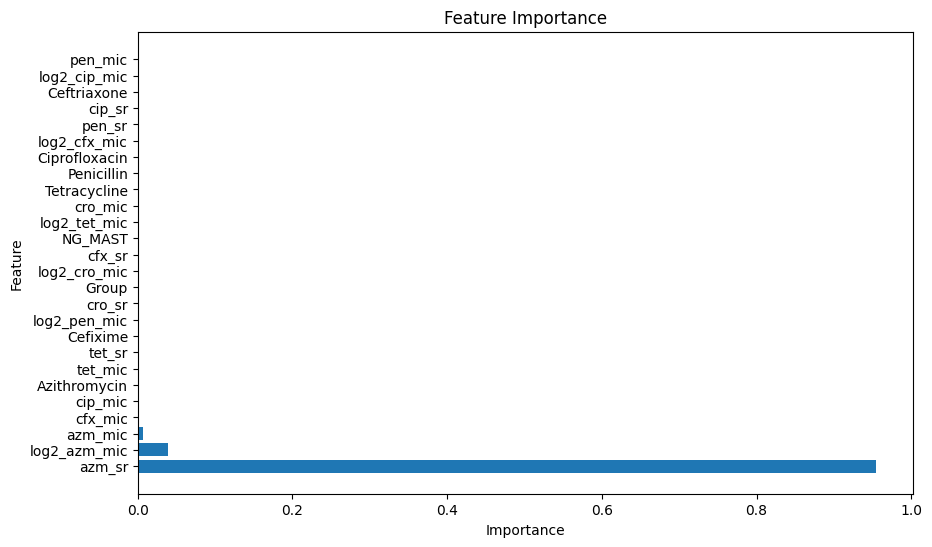

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Step 1: Use RandomForestRegressor for continuous targets (regression)
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model with the training data
rf_regressor.fit(X_train_scaled, y_train)

# Step 2: Access feature importances after fitting
feature_importances = rf_regressor.feature_importances_

# Get the feature names
features = X.columns

# Sort feature importances in descending order
sorted_idx = np.argsort(feature_importances)[::-1]

# Step 3: Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], feature_importances[sorted_idx])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
